# This part is for dataloader test for improved cycle gan

In [1]:
# Import packages
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model, improved_losses
from util.visualizer import Visualizer
import sys
import os
import torch
import numpy as np
# Import plt
import matplotlib.pyplot as plt
import shutil
import subprocess



In [11]:
# Simulate command-line arguments
sys.argv = [
    'train.py',  # script name, traditionally argv[0]
    '--dataroot', '/home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse',
    '--name', 'cycle_gan',
    '--results_dir', '/home/frozen/CV_FinalProject/Cell_cycleGAN//results/training_dataset_tiledGOWT_Fakulty_Inverse/Test',
    '--model', 'cycle_gan',
    '--batch_size', '24',
    '--n_epochs', '30',
    '--n_epochs_decay', '30',
    '--epoch_count', '1',
    '--dataset_mode', 'improvedunaligned',
    '--direction', 'AtoB',
    '--model', 'seg_cycle_gan',
    '--input_nc', '1',
    '--output_nc', '3',
]

# Define the options for training
opt = TrainOptions().parse()



----------------- Options ---------------
               batch_size: 24                            	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: /home/frozen/CV_FinalProject/Cell_cycleGAN/results/training_dataset_tiledGOWT_Fakulty_Inverse/Test/cycle_gan	[default: None]
           continue_train: False                         
                crop_size: 128                           
                 dataroot: /home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse	[default: None]
             dataset_mode: improvedunaligned             	[default: unaligned]
                direction: AtoB                          	[default: BtoA]
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 80

In [12]:
# Create the dataset
dataset = create_dataset(opt)

# Check Length of dataset
print('The length of the dataset is:', len(dataset))


dataset [ImprovedUnalignedDataset] was created
The length of the dataset is: 576


In [13]:
# Get one sample from the dataset
sample = next(iter(dataset)) 


# Display the sample
sample_A = sample['A']
sample_B = sample['B']
sample_A_GT = sample['A_GT']

# Print paths of first A and A_GT
print('Path of A:', sample['A_paths'][0])
print('Path of A_GT:', sample['A_GT_paths'][0])

Path of A: /home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse/trainA/inverted_01_121.tiff
Path of A_GT: /home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse/trainA_GT/01_121.tiff


In [14]:
# Denormalize the image from [0,1] to [0,255]
sample_A = (sample_A + 1)/2 * 255.0
sample_B = (sample_B + 1)/2 * 255.0
sample_A_GT = (sample_A_GT + 1)/2 * 255.0

# Reshape the tensors
sample_A_Vis = sample_A[0].permute(1,2,0)
sample_A_Vis = sample_A_Vis.squeeze()
sample_B_Vis = sample_B[0].permute(1,2,0)
sample_A_GT_Vis = sample_A_GT[0].permute(1,2,0)

# Convert the tensor to numpy and convert data type to uint8
sample_A_Vis = sample_A_Vis.numpy().astype(np.uint8)
sample_B_Vis = sample_B_Vis.numpy().astype(np.uint8)
sample_A_GT_Vis = sample_A_GT_Vis.numpy().astype(np.uint8)

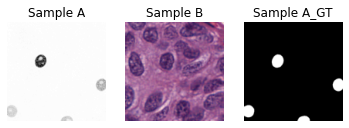

In [15]:


# Display images
plt.figure()
plt.subplot(1, 3, 1)
# Display sample A as grayscale
plt.imshow(sample_A_Vis, cmap='gray')
plt.title('Sample A')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_B_Vis)
plt.title('Sample B')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sample_A_GT_Vis)
plt.title('Sample A_GT')
plt.axis('off')

plt.show()


In [16]:
# Create the model
model = create_model(opt)

# Set up the model
model.setup(opt)


initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [SegCycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 7.831 M
[Network G_B] Total number of parameters : 7.831 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.763 M
-----------------------------------------------


In [ ]:
visualizer = Visualizer(opt) 
dataset_size = len(dataset)

# Training Loop
total_iters = 0
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0
    visualizer.reset() 
    # Update learning rate
    model.update_learning_rate()

    # Iterate over dataset
    for i, data in enumerate(dataset):
        iter_start_time = time.time()
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)
        model.optimize_parameters()

        if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
            if opt.display_id > 0:
                visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))

    

Setting up a new session...
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/urllib3/connection.py", line 159, in _new_conn
    conn = connection.create_connection(
  File "/opt/conda/lib/python3.8/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/opt/conda/lib/python3.8/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py", line 392, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.8/http/client.py", line 1255, in request
    self._send_request(method,

Exception in user code:
------------------------------------------------------------


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
Visdom python client failed to establish socket to get messages from the server. This feature is optional and can be disabled by initializing Visdom with `use_incoming_socket=False`, which will prevent waiting for this request to timeout.




Could not connect to Visdom server. 
 Trying to start a server....
Command: /opt/conda/bin/python -m visdom.server -p 8097 &>/dev/null &
create web directory /home/frozen/CV_FinalProject/Cell_cycleGAN/results/training_dataset_tiledGOWT_Fakulty_Inverse/Test/cycle_gan/web...
learning rate 0.0001000 -> 0.0001000


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


End of epoch 1 / 60 	 Time Taken: 47 sec
learning rate 0.0001000 -> 0.0001000
(epoch: 2, iters: 24, time: 0.082, data: 0.390) D_A: 0.437 G_A: 0.535 cycle_A: 0.669 idt_A: 0.000 D_B: 0.252 G_B: 0.951 cycle_B: 2.443 idt_B: 0.000 GT_fake: 0.914 color_variation_fake: 0.836 hsv_fake: 0.051 GT_rec: 0.924 color_variation_rec: 0.855 hsv_rec: 0.053 
End of epoch 2 / 60 	 Time Taken: 47 sec
learning rate 0.0001000 -> 0.0001000
(epoch: 3, iters: 48, time: 0.083, data: 0.002) D_A: 0.712 G_A: 0.973 cycle_A: 0.143 idt_A: 0.000 D_B: 0.239 G_B: 0.242 cycle_B: 2.123 idt_B: 0.000 GT_fake: 0.929 color_variation_fake: 0.844 hsv_fake: 0.021 GT_rec: 0.930 color_variation_rec: 0.866 hsv_rec: 0.045 
End of epoch 3 / 60 	 Time Taken: 46 sec
learning rate 0.0001000 -> 0.0001000
(epoch: 4, iters: 72, time: 0.083, data: 0.001) D_A: 0.338 G_A: 0.433 cycle_A: 0.103 idt_A: 0.000 D_B: 0.159 G_B: 0.381 cycle_B: 1.709 idt_B: 0.000 GT_fake: 0.925 color_variation_fake: 0.874 hsv_fake: 0.039 GT_rec: 0.925 color_variation_r

dict_keys(['iters', 'time', 'data', 'D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B', 'GT_fake', 'color_variation_fake', 'hsv_fake', 'GT_rec', 'color_variation_rec', 'hsv_rec'])


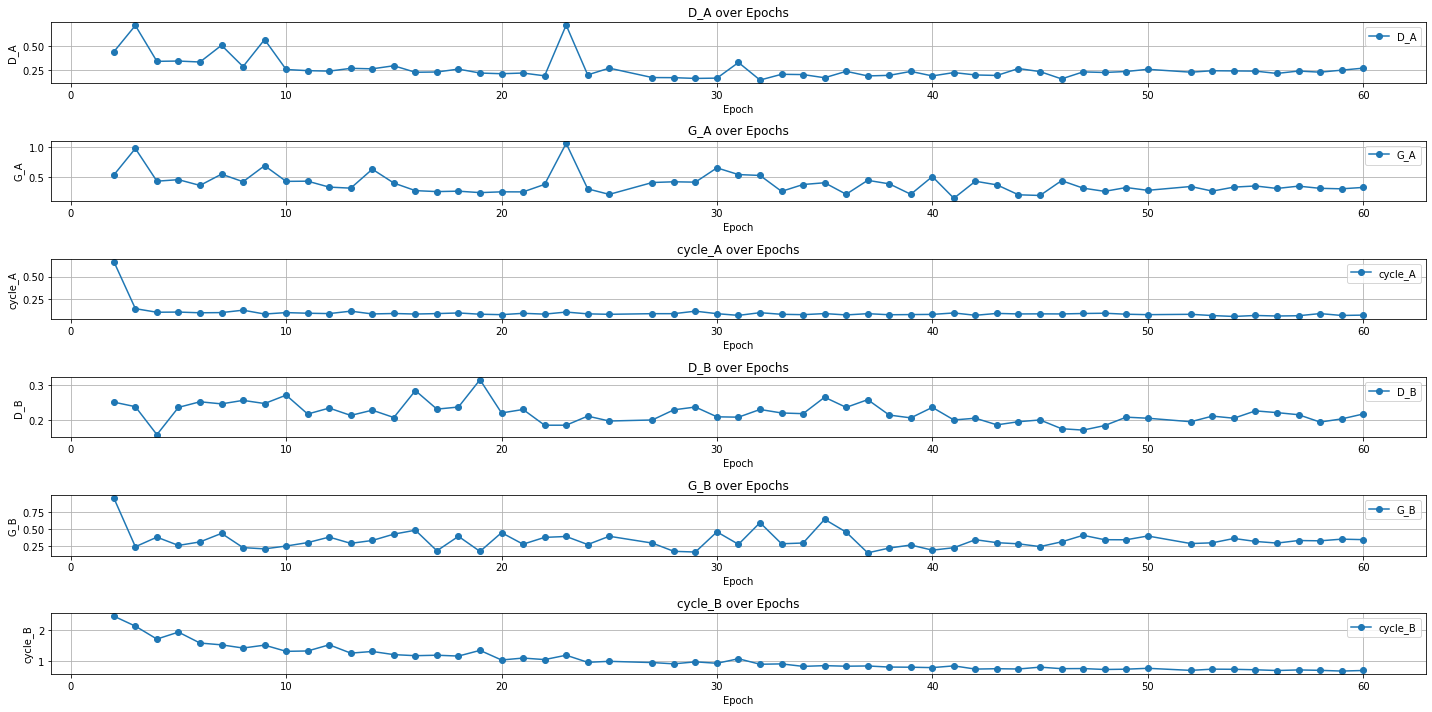

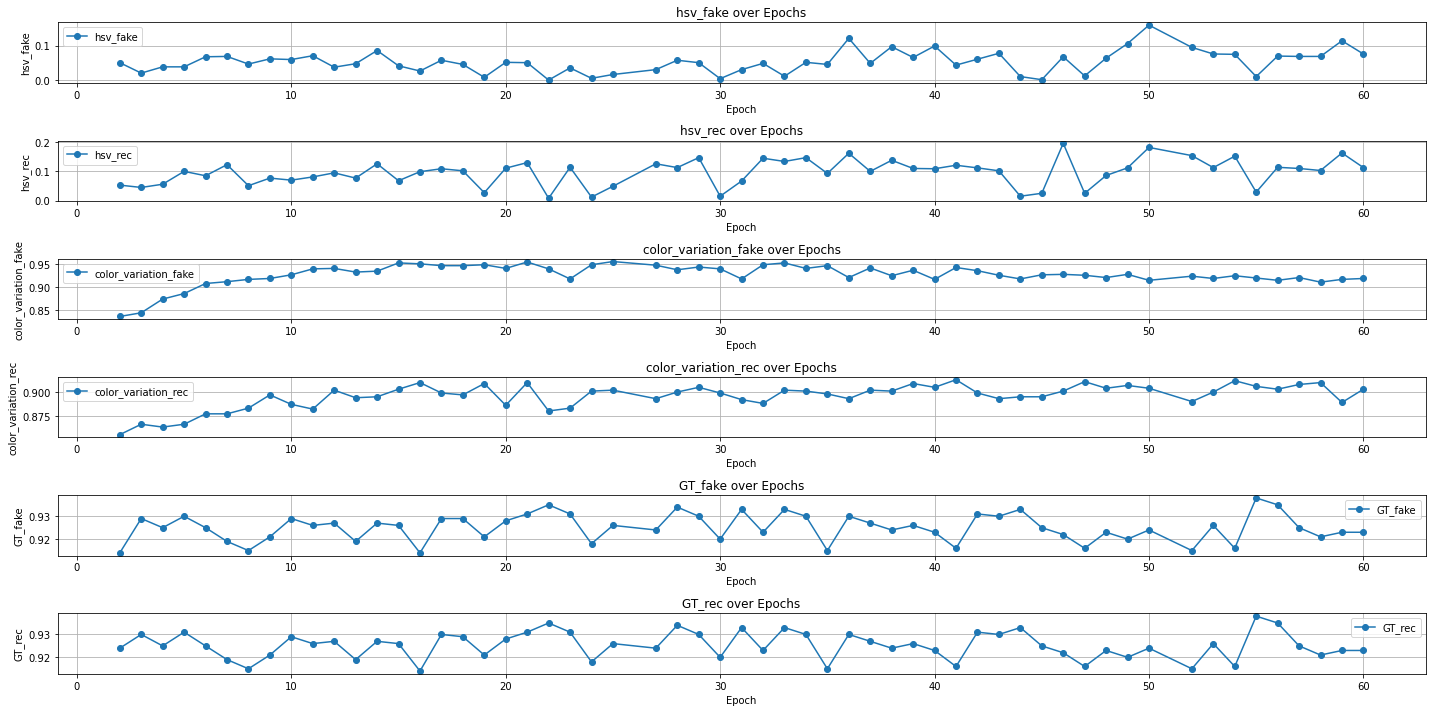

In [32]:
from collections import defaultdict

# Function to load log data from a file, skipping the first line
def load_log_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()[1:]  # Skip the first line
        return ''.join(lines)

# Specify the path to the log file
log_file_path = os.path.join(opt.results_dir, 'cycle_gan/loss_log.txt')

# Load log data from a file
log_data = load_log_data(log_file_path).strip().split('\n')


# Parsing the data
all_metrics = defaultdict(lambda: defaultdict(list))

# Parse the log data
for line in log_data:
    # Clean the line and split into parts
    parts = line.replace('(', '').replace(')', '').split()
    epoch = int(parts[1].strip(','))  # Get epoch number

    for i in range(2, len(parts), 2):  # Iterate through the parts in steps of 2
        if ':' in parts[i]:
            metric = parts[i].rstrip(':')
            value = float(parts[i + 1].strip(','))
            all_metrics[metric][epoch].append(value)

print(all_metrics.keys())

def plot_metrics_for_selected(all_metrics, selected_metrics):
    plt.figure(figsize=(20, 10))
    num_plots = len(selected_metrics)
    plot_count = 1
    for metric in selected_metrics:
        if metric in all_metrics:  # Check if the metric exists in the parsed data
            epochs_values = all_metrics[metric]
            epochs = sorted(epochs_values.keys())
            values = [np.mean(epochs_values[epoch]) for epoch in epochs]  # Mean if multiple values per epoch
            plt.subplot(num_plots, 1, plot_count)
            plt.plot(epochs, values, marker='o', linestyle='-', label=metric)
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(f'{metric} over Epochs')
            plt.legend()
            plt.grid(True)
            plot_count += 1
    plt.tight_layout()
    plt.show()


general_metrics = ['D_A', 'G_A', 'cycle_A', 'D_B', 'G_B', 'cycle_B']
color_and_gt_metrics = ['hsv_fake', 'hsv_rec', 'color_variation_fake', 'color_variation_rec', 'GT_fake', 'GT_rec']

# Assuming all_metrics is your dictionary of metrics
plot_metrics_for_selected(all_metrics, general_metrics)
plot_metrics_for_selected(all_metrics, color_and_gt_metrics)

In [34]:
# Copy models to the results directory
src_dir = os.path.join(opt.results_dir, 'cycle_gan')

# Destination directory to copy the models
dst_dir = '/home/frozen/CV_FinalProject/Cell_cycleGAN/staining_results/Improved_GOWT_Test'


# Loop through the numbers 5 to 60 in increments of 5
for i in range(5, 65, 5):
    epoch_dir_name = f'Epoch{i}'
    epoch_dir_path = os.path.join(dst_dir, epoch_dir_name)
    
    # Create the sub-directory if it doesn't exist
    if not os.path.exists(epoch_dir_path):
        os.makedirs(epoch_dir_path)

    # File names to look for
    files_to_copy = [f"{i}_net_D_A.pth", f"{i}_net_D_B.pth", f"{i}_net_G_A.pth", f"{i}_net_G_B.pth"]
    
    for file_name in files_to_copy:
        src_file_path = os.path.join(src_dir, file_name)
        
        # Check if the file exists before attempting to copy it
        if os.path.exists(src_file_path):
            new_file_name = file_name.replace(f"{i}_", "latest_")
            dst_file_path = os.path.join(epoch_dir_path, new_file_name)
            
            # Copy the file
            shutil.copy2(src_file_path, dst_file_path)
            print(f"Copied {src_file_path} to {dst_file_path}")


Copied /home/frozen/CV_FinalProject/Cell_cycleGAN//results/training_dataset_tiledGOWT_Fakulty_Inverse/Test/cycle_gan/5_net_D_A.pth to /home/frozen/CV_FinalProject/Cell_cycleGAN/staining_results/Improved_GOWT_Test/Epoch5/latest_net_D_A.pth
Copied /home/frozen/CV_FinalProject/Cell_cycleGAN//results/training_dataset_tiledGOWT_Fakulty_Inverse/Test/cycle_gan/5_net_D_B.pth to /home/frozen/CV_FinalProject/Cell_cycleGAN/staining_results/Improved_GOWT_Test/Epoch5/latest_net_D_B.pth
Copied /home/frozen/CV_FinalProject/Cell_cycleGAN//results/training_dataset_tiledGOWT_Fakulty_Inverse/Test/cycle_gan/5_net_G_A.pth to /home/frozen/CV_FinalProject/Cell_cycleGAN/staining_results/Improved_GOWT_Test/Epoch5/latest_net_G_A.pth
Copied /home/frozen/CV_FinalProject/Cell_cycleGAN//results/training_dataset_tiledGOWT_Fakulty_Inverse/Test/cycle_gan/5_net_G_B.pth to /home/frozen/CV_FinalProject/Cell_cycleGAN/staining_results/Improved_GOWT_Test/Epoch5/latest_net_G_B.pth
Copied /home/frozen/CV_FinalProject/Cell_cyc

In [41]:
# Initial Prameeters (extract it from comment)
""" 
python test.py --dataroot /home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse --name /home/frozen/CV_FinalProject/Cell_cycleGAN/staining_results/Improved_GOWT_Test/Epoch5 --model seg_cycle_gan --no_dropout --input_nc 1 --output_nc 3 --dataset_mode improvedunaligned
"""



dataroot = '/home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse'
# Loop the dataroots stored before
for i in range(5, 65, 5):
    epoch_dir_name = f'Epoch{i}'
    modelroot = os.path.join(dst_dir, epoch_dir_name)
    
    # Command to test the model
    command = f"python test.py --dataroot {dataroot} --name {modelroot} --model seg_cycle_gan --no_dropout --input_nc 1 --output_nc 3 --dataset_mode improvedunaligned"

    # Execute the command
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    # Print the output
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)

STDOUT: ----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /home/frozen/CV_FinalProject/Cell_cycleGAN/staining_results/Improved_GOWT_Test/Epoch5	[default: None]
                crop_size: 128                           
                 dataroot: /home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse	[default: None]
             dataset_mode: improvedunaligned             	[default: unaligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
               

In [42]:
# Move data to certain directory for evaluation

# Source directory path
source_base_path = '/home/frozen/CV_FinalProject/Cell_cycleGAN/staining_results/Improved_GOWT_Test/'

# Target directory path
target_base_path = '/home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/'

# Iterate over each epoch folder
for epoch in range(5, 65, 5):  # Starts at Epoch5 and ends at Epoch60, incrementing by 5
    source_epoch_path = os.path.join(source_base_path, f'Epoch{epoch}', 'test_latest', 'images')
    target_epoch_path = os.path.join(target_base_path, f'Epoch{epoch}')
    
    # Create the corresponding target epoch directory if it doesn't exist
    if not os.path.exists(target_epoch_path):
        os.makedirs(target_epoch_path)
    
    # Iterate over each file in the source epoch directory
    for filename in os.listdir(source_epoch_path):
        if filename.endswith('_fake_B.png'):
            # Extract the original part of the name
            original_part = filename.split('_')[1]
            index_part = filename.split('_')[2].split('_fake_B.png')[0]

            # Construct the new filename
            new_filename = f'{original_part}_{index_part}.png'

            # Construct the full path for source and target
            source_file_path = os.path.join(source_epoch_path, filename)
            target_file_path = os.path.join(target_epoch_path, new_filename)

            # Copy the file
            shutil.copy2(source_file_path, target_file_path)

In [7]:
# Initialize the evaluation command parameters

# Initialize the evaluation command parameters
stained_img_base_path = '/home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/'
ground_truth_img_base_path = '/home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/'
colorized_img_base_path = '/home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse/testB'

# Adjusted command to use positional arguments
command = f"python /home/frozen/CV_FinalProject/Cell_cycleGAN/evaluation/Stain_Evaluation.py {stained_img_base_path} {ground_truth_img_base_path} {colorized_img_base_path}"

# Execute the command
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Print the output
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

STDOUT: Starting evaluation for epoch 5
Evaluating image: /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/Epoch5/01_478.png and /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/GT/01_478.tiff
Evaluating image: /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/Epoch5/01_477.png and /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/GT/01_477.tiff
Evaluating image: /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/Epoch5/01_487.png and /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/GT/01_487.tiff
Evaluating image: /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/Epoch5/01_471.png and /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOWT_Test/GT/01_471.tiff
Evaluating image: /home/frozen/CV_FinalProject/Cell_cycleGAN/Evaluation_Dataset/Improved_GOW